In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os; print(os.getcwd())
import socket; print(socket.gethostname())
from glob import glob
import json

import truncator as u
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
from IPython.display import display
from ipywidgets import widgets

/home/aljubetic/AF2/projects/2023-03-03__MP3-PNIC-all-by-all-v3
headnode


In [ ]:
ids = u.read_file_lines('data/duet.ids', trim=True)

In [18]:
df = pd.read_csv('out/01__multimer-v2__r6/AF2.csv.gz', index_col=0)


print(list(df.columns))
df.head(5)


['id1', 'id2', 'base_name', 'max_pae', 'pae', 'plddt', 'ptm', 'model', 'msa_mode', 'model_type', 'num_models', 'num_recycles']


,id1,id2,base_name,max_pae,pae,plddt,ptm,model,msa_mode,model_type,num_models,num_recycles
0,B_HT_DHD_51,A_HT_DHD_72,B_HT_DHD_51__A_HT_DHD_72,31.75,12.768497,56.867714,0.49,multimer_v2,single_sequence,multimer-v2,5,6
1,ZCON_37_LL_B,B_HT_DHD_15,ZCON_37_LL_B__B_HT_DHD_15,31.75,14.876869,56.812000,0.44,multimer_v2,single_sequence,multimer-v2,5,6
2,B_HT_DHD_67,B_HT_DHD_67,B_HT_DHD_67__B_HT_DHD_67,31.75,12.260034,53.971357,0.41,multimer_v2,single_sequence,multimer-v2,5,6
3,B_HT_DHD_84,B_HT_DHD_51,B_HT_DHD_84__B_HT_DHD_51,31.75,9.493309,73.098786,0.62,multimer_v2,single_sequence,multimer-v2,5,6
4,ZCON_155_cutT2_A,A_HT_DHD_56,ZCON_155_cutT2_A__A_HT_DHD_56,31.75,14.862911,58.524643,0.46,multimer_v2,single_sequence,multimer-v2,5,6


model=="multimer-v2"  and num_recycles==6


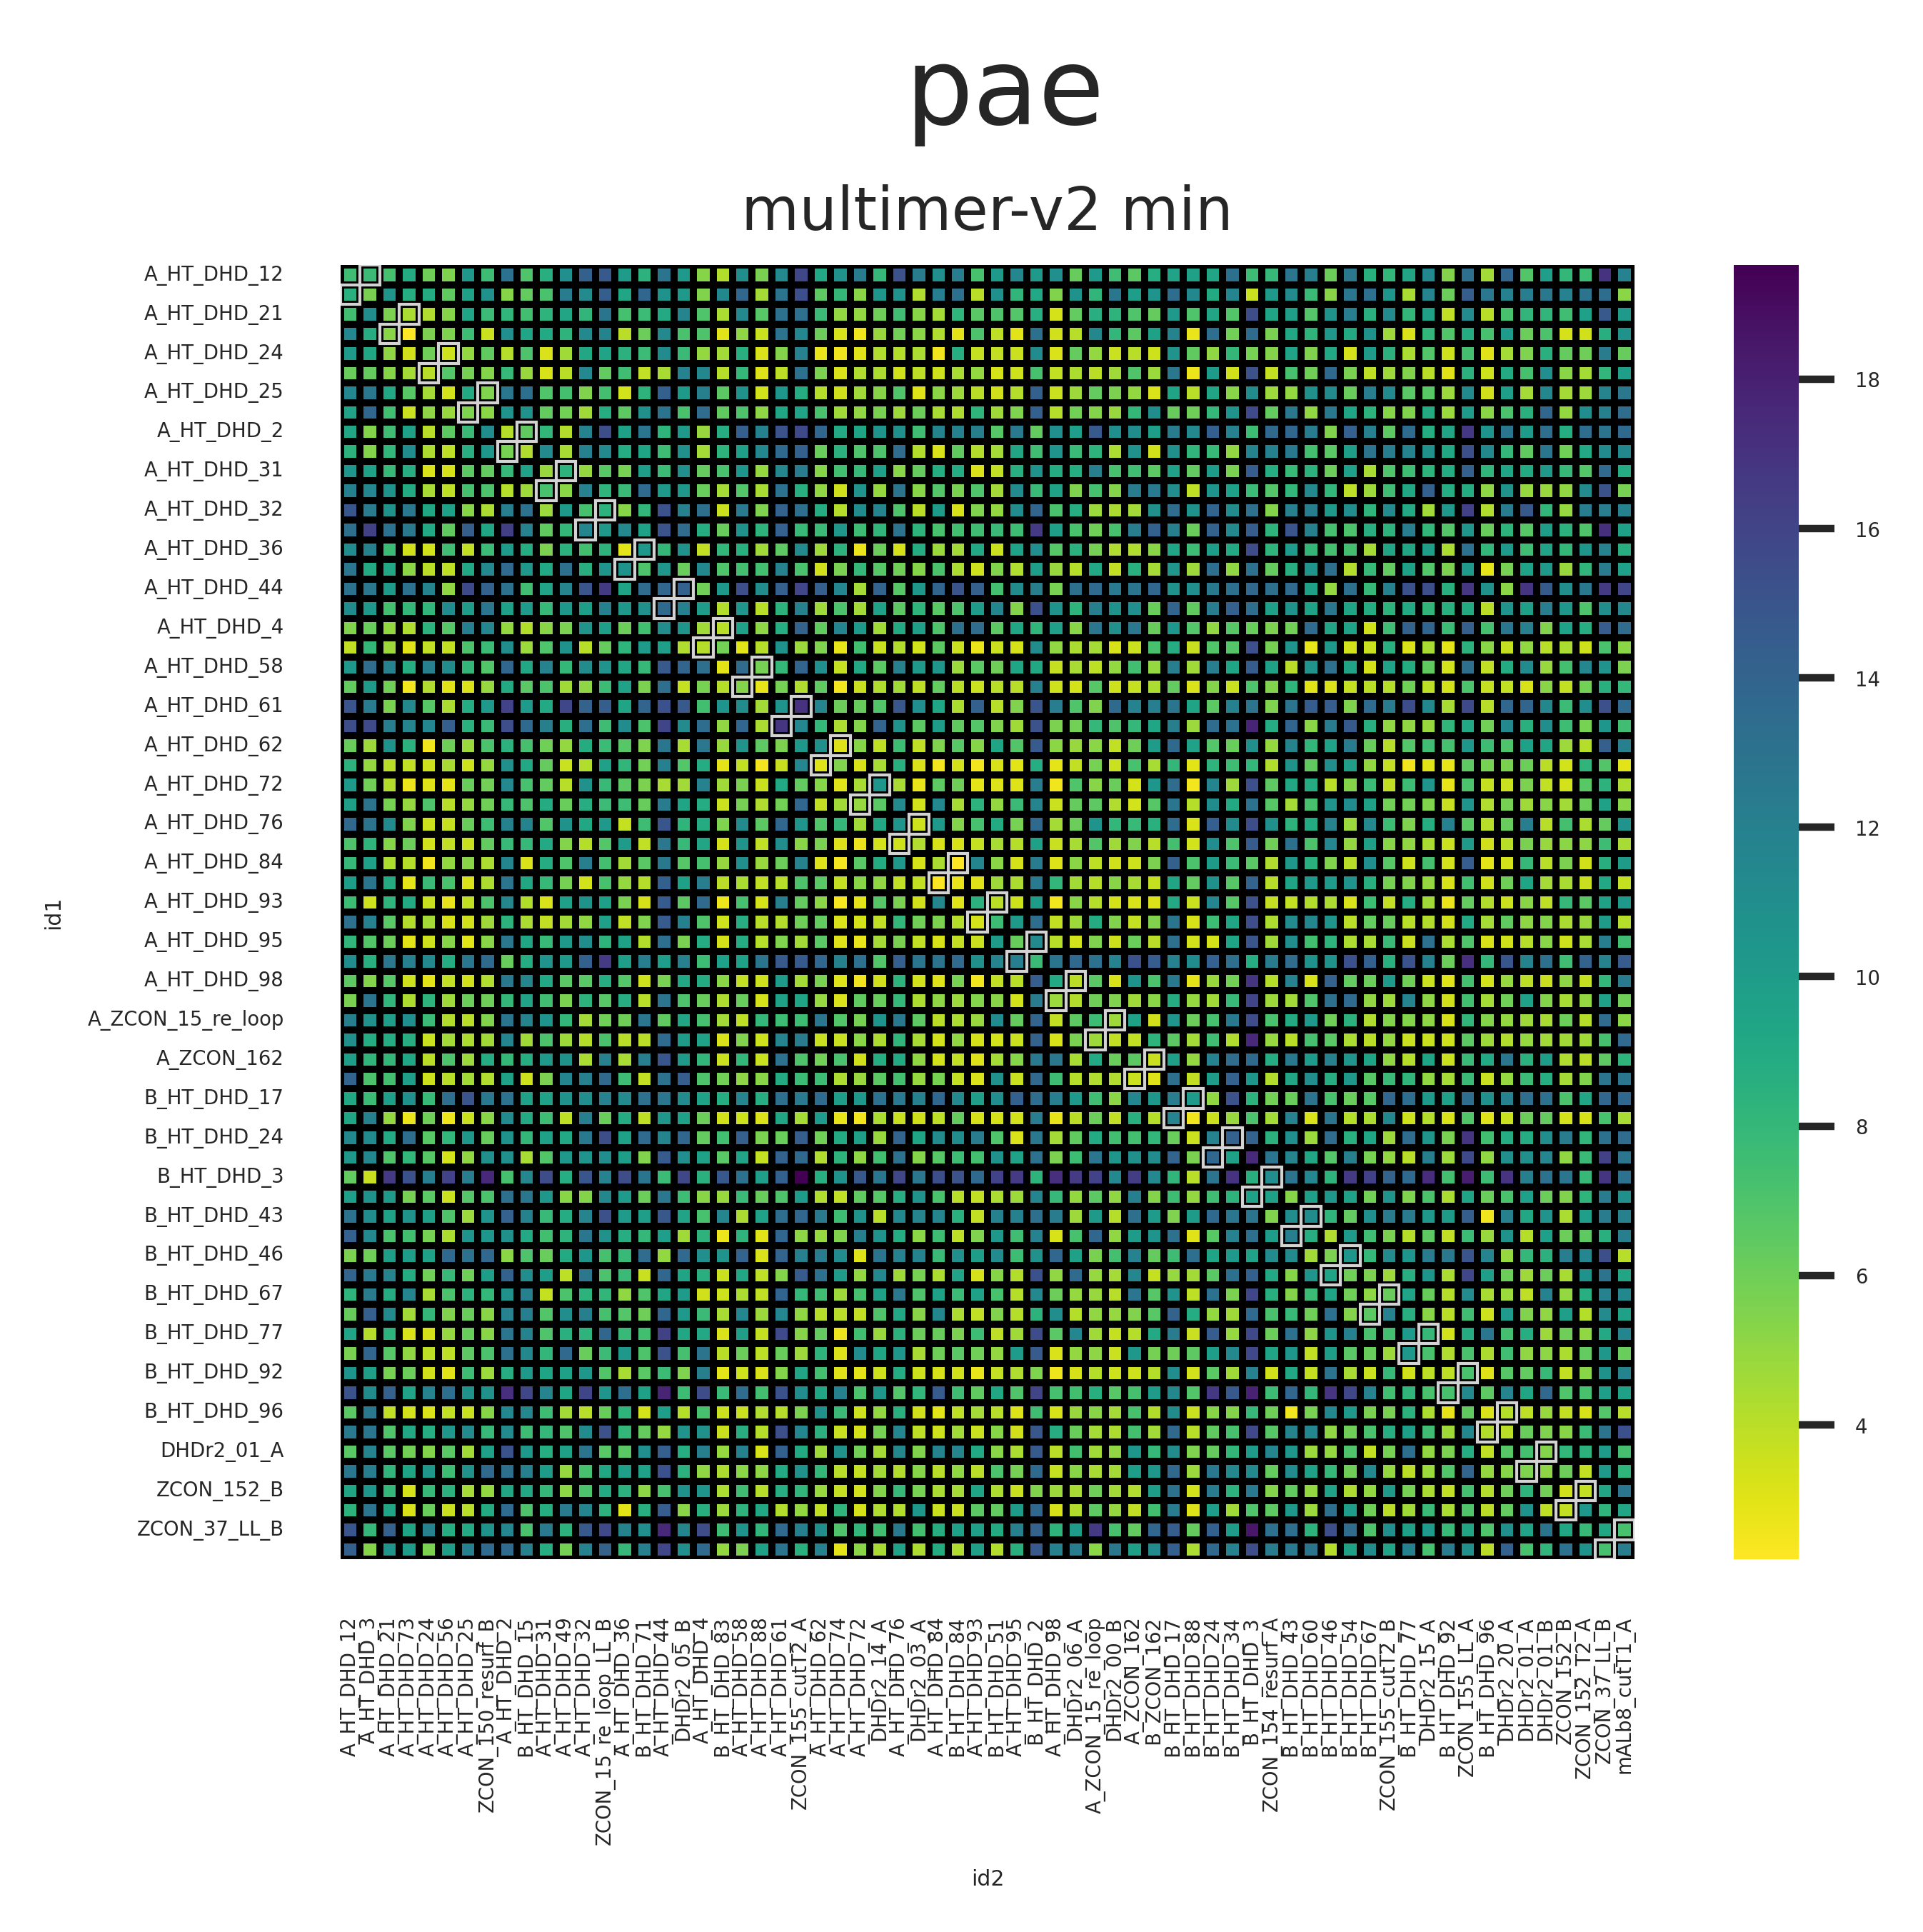

In [49]:
ranges_by_field = dict(
    mean_plddt = (75,100),
    IA_dSASA_int = (1200, 1800),
)
def plot(df, field, model_number, model_type, extra_query='', pdb='', reverse_color_scale=False, annotate=False, ids=''):
    
    if extra_query:
        extra_query = ' and ' + extra_query
    if model_number.isnumeric():
        df = df.query(f'model_type=="{model_type}" and model=={model_number} {extra_query}')
        mat = df 
    else:
        print(f'model=="{model_type}" {extra_query}')
        df = df.query(f'model_type=="{model_type}" {extra_query}')
        mat = df.groupby('id1 id2'.split())
        
        #calls the mean, min, max function of mat group by
        mat = getattr(mat, model_number)()
        
    
    #df = df.sort_values(by=field, ascending=True)
    
    if pdb:
        id1 , id2 = pdb.split()
        print(id1, id2)    
        pdb_filt = df.query(f'id1 == "{id1}" and id2 == "{id2}"')
        
        for path in pdb_filt.full_name.values:
            print(f'load {path}')


    mat = mat.pivot_table(values=field, index='id1', columns='id2', sort=False)
    
    # Reorder the pair
    if ids:
        mat = mat.reindex(columns=ids, labels=ids)
    
    if field in ranges_by_field:
        vmin, vmax = ranges_by_field[field]
    else:
        vmin, vmax = None, None
    
    if reverse_color_scale:
        cmap ='viridis_r'
    else:
        cmap='viridis'
    #sns.heatmap(mat, cmap=cmap, linewidths=1, linecolor='black', annot=annotate, annot_kws={"size": 5}, fmt=".1f", vmin=vmin, vmax=vmax)
    sns.heatmap(mat, cmap=cmap, linewidths=1, linecolor='black', annot=False, annot_kws={"size": 1}, fmt=".1f", vmin=vmin, vmax=vmax)
    plt.suptitle(field, y=1.01, fontsize=18)
    plt.title(f'{model_type} {model_number}', fontsize=10)
    
    ax = plt.gca()
    for i in range(0, len(mat), 2): 
        ax.add_patch( plt.Rectangle((i, i+1), 1, 1, fill=False, edgecolor='lightgray', lw=0.5) )
        ax.add_patch( plt.Rectangle((i+1, i), 1, 1, fill=False, edgecolor='lightgray', lw=0.5) )
    #return df
    ax.set_aspect('equal','box')

mpl.rcParams['figure.dpi'] = 600
sns.set_context("paper")
sns.set(font_scale=0.3)
plot(df, 'pae', 'min', 'multimer-v2', 'num_recycles==6', '',  ids=ids, reverse_color_scale=True)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
interact(plot, df=fixed(df), model_type=['monomer_ptm','multimer', 'multimer_v2'], 
model_number='1 2 3 4 5 min max mean median stdev'.split(),
msa_depth=[512,1],
field='mean_plddt mean_pae_interaction pTMscore elapsed_time IA_dG_cross IA_dSASA_int IA_dSASA_polar IA_sc_value IA_delta_unsatHbonds IA_nres_int IA_per_residue_energy_int IA_sc_value ptm iptm msa_depth\
   cms sc2 sc2_int_area sc2_median_dist vbuns sbuns score_per_res timed'.split(),
pdb='P01 P02', reverse_color_scale=False, annotate=False)

In [ ]:
grid = widgets.GridspecLayout(12, 12)
def on_btn_click(btn):
    print(btn.description)

for i in range(12):
    for j in range(12):
        grid[i, j] = widgets.Button(description="[P%d, P%d]"%(i,j), button_style="primary")

display(grid)

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot